In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
# Import tensorflow.
import tensorflow as tf

# PIL (Pillow) for working with images.
import PIL
from PIL import Image , ImageOps

# Used for globbing up directories.
import glob

# The Data Tools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the Keras tools.
from tensorflow import keras

# Network type.
from tensorflow.keras.models import Sequential

# Layer information.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# For editing images. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical

print("Tensorflow version:", tf.__version__)
print("Pandas version:", pd.__version__)
print("Keras version:", keras.__version__)
print("Pillow version:",PIL.__version__,"\n")

physical_devices = tf.config.list_physical_devices('GPU') 
print("GPU's:",physical_devices)
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

Tensorflow version: 2.1.0
Pandas version: 1.1.5
Keras version: 2.2.4-tf
Pillow version: 8.1.0 

GPU's: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## **Image Pipeline**

Set the path the the images. This need to be structured as classes are in directories together. 

In [5]:
src_path_train = "../Data/mnist_images/trainingSet/trainingSet"

The ImageDataGenerator allows us to modify the images to increase the size of the data set. This will be useful if we don't have enough labeled images but we sill want to train the network. 

In [6]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
        rescale = 1 / 255.0,
        #rotation_range=20,
        #zoom_range=5,
        #width_shift_range=5,
        #height_shift_range=5,
        #shear_range=100,
        horizontal_flip=True,
        #fill_mode="nearest",
        validation_split=0.20)

In the next cell we are going to setup the data flow pipeline using flow_from_directory. This tool allows us to use Keras to feed the images from the directories into the network. It will also allow us to set a batch size as well as a few other setting for the network. 

In [7]:
batch_size = 100
train_generator = datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(28, 28),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

Found 33607 images belonging to 10 classes.


## **Check a few Images**

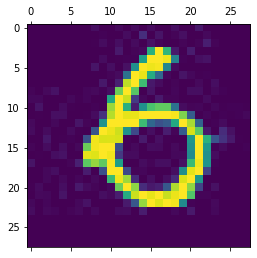

In [8]:
image_list = []

for images,labels in next(zip(train_generator)):
    for i in range(10): # can't be greater than 20
        image_list.append(images[i])

plt.matshow(image_list[0])
plt.show()

In [9]:
np.shape(image_list)

(10, 28, 28, 1)

## **The Model**

In [123]:
model = Sequential()

model.add(Conv2D(1, kernel_size=(5,5),activation='relu', input_shape=(28, 28, 1), use_bias=False))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten(input_shape=(10,10,1)))

model.add(Dense(300, activation='relu'))
#model.add(Dropout(.5))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
          
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 1)         25        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 1)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 300)               43500     
_________________________________________________________________
dense_33 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_35 (Dense)             (None, 10)               

## **Training**

In [114]:
model.fit(train_generator, steps_per_epoch = train_generator.n//train_generator.batch_size, epochs=3)

  ...
    to  
  ['...']
Train for 336 steps
Epoch 1/3
336/336 [==============================] - 7s 21ms/step - loss: 0.5401 - accuracy: 0.8259
Epoch 2/3
336/336 [==============================] - 6s 19ms/step - loss: 0.2427 - accuracy: 0.9240
Epoch 3/3
336/336 [==============================] - 6s 17ms/step - loss: 0.1853 - accuracy: 0.9412


In [115]:
from tensorflow.keras import backend as K

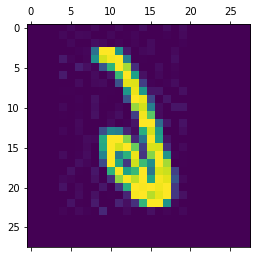

In [116]:
layer_testing_image = []

for images,labels in next(zip(train_generator)):
    for i in range(1): # can't be greater than 20
        layer_testing_image.append(images[i])
        
plt.matshow(layer_testing_image[0])
plt.show()

In [117]:
my_layer_0 = model.layers[0]
print(my_layer_0.input_shape)
print(my_layer_0.output_shape)

(None, 28, 28, 1)
(None, 24, 24, 1)


(1, 1, 24, 24, 1)


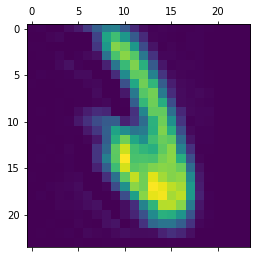

In [118]:
func_0 = K.function(model.inputs, [my_layer_0.output])
output_0 = func_0(np.array(layer_testing_image))

print(np.shape(output_0))
plt.matshow(output_0[0][0])
plt.show()

In [119]:
my_layer_1 = model.layers[1]

print(my_layer_1.input_shape)
print(my_layer_1.output_shape)

(None, 24, 24, 1)
(None, 12, 12, 1)


(1, 1, 10, 10, 1)


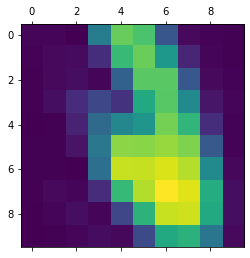

In [120]:
func_1 = K.function(model.inputs, [my_layer_1.output])

output_1 = func_1(output_0[0])

print(np.shape(output_1))
plt.matshow(output_1[0][0])
plt.show()

In [121]:
my_layer_2 = model.layers[2]

print(my_layer_2.input_shape)
print(my_layer_2.output_shape)


(None, 12, 12, 1)
(None, 144)


In [122]:
func_2 = K.function(model.inputs, [my_layer_2.output])

output_2 = func_2(output_1)[0][0][:,:,5]

plt.matshow(output_2)
plt.show()

InvalidArgumentError:  Input to reshape is a tensor with 9 values, but the requested shape requires a multiple of 144
	 [[node flatten_7/Reshape (defined at <ipython-input-122-2b9f6d71160b>:1) ]] [Op:__inference_keras_scratch_graph_28368]

Function call stack:
keras_scratch_graph
